In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
dataset_path = "/content/drive/MyDrive/CompVis Projek/UANGUVTERBARU"

In [12]:
names = ['1 RIBU ASLI', '1 RIBU PALSU', '10 RIBU ASLI', '10 RIBU PALSU',
         '100 RIBU ASLI', '100 RIBU PALSU', '20 RIBU ASLI', '20 RIBU PALSU',
         '5 RIBU ASLI', '5 RIBU PALSU', '50 RIBU ASLI', '50 RIBU PALSU']

In [13]:
def augment_image(image, bbox):
    augmented_images = []
    augmented_bboxes = []

    # Rotasi kecil
    for angle in [-10, 10]:
        h, w = image.shape[:2]
        rotation_matrix = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
        rotated = cv2.warpAffine(image, rotation_matrix, (w, h))

        # Update bounding box
        corners = np.array([
            [bbox[0], bbox[1], 1],
            [bbox[2], bbox[1], 1],
            [bbox[2], bbox[3], 1],
            [bbox[0], bbox[3], 1]
        ])
        rotated_corners = np.dot(rotation_matrix, corners.T).T
        x_min, y_min = np.min(rotated_corners, axis=0)[:2]
        x_max, y_max = np.max(rotated_corners, axis=0)[:2]

        # Pastikan IoU valid
        rotated_bbox = [int(x_min), int(y_min), int(x_max), int(y_max)]
        iou = calculate_iou(bbox, rotated_bbox)
        if iou > 0.5:
            augmented_images.append(rotated)
            augmented_bboxes.append(rotated_bbox)

    # Ubah kecerahan
    for brightness_factor in [0.8, 1.2]:
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv[:, :, 2] = np.clip(hsv[:, :, 2] * brightness_factor, 0, 255).astype(np.uint8)
        bright_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        augmented_images.append(bright_img)
        augmented_bboxes.append(bbox)

    noise = np.random.normal(0, 10, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    augmented_images.append(noisy_image)
    augmented_bboxes.append(bbox)

    return augmented_images, augmented_bboxes

In [14]:
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Area overlap
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Area total
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [15]:
# microtext
def extract_microtext(image_gray):
    edges = cv2.Canny(image_gray, 50, 150)
    return np.sum(edges) / edges.size

# warna
def extract_color(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue_mean = np.mean(hsv[:, :, 0])
    sat_mean = np.mean(hsv[:, :, 1])
    val_mean = np.mean(hsv[:, :, 2])

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    intensity_mean = np.mean(gray)

    red_mean = np.mean(image[:, :, 2])
    green_mean = np.mean(image[:, :, 1])
    blue_mean = np.mean(image[:, :, 0])

    return hue_mean, sat_mean, val_mean, intensity_mean, red_mean, green_mean, blue_mean

# benang pengaman
def detect_thread(image_gray):
    _, thresh = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
    thread = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel)
    return np.sum(thread) / thread.size


def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray=cv2.equalizeHist(gray)
    microtext_density = extract_microtext(gray)
    hue, saturation, value, intensity, red, green, blue = extract_color(image)
    thread_density = detect_thread(gray)
    return [microtext_density, hue, saturation, value, intensity, red, green, blue, thread_density]


In [16]:
def load_dataset(folder_path, resize_dim=(512, 512)):
    images_folder = os.path.join(folder_path, "images")
    labels_folder = os.path.join(folder_path, "labels")

    data = []
    labels = []

    for img_name in os.listdir(images_folder):
        if img_name.endswith(".jpg"):
            img_path = os.path.join(images_folder, img_name)
            label_path = os.path.join(labels_folder, os.path.splitext(img_name)[0] + ".txt")

            img = cv2.imread(img_path)
            if img is not None and os.path.exists(label_path):
                with open(label_path, "r") as f:
                    label_data = f.readline().strip().split()
                    class_idx = int(label_data[0])
                    x, y, w, h = map(float, label_data[1:])
                    bbox = [
                        int((x - w / 2) * img.shape[1]),
                        int((y - h / 2) * img.shape[0]),
                        int((x + w / 2) * img.shape[1]),
                        int((y + h / 2) * img.shape[0]),
                    ]

                original_shape = img.shape[:2]
                img = cv2.resize(img, resize_dim)
                scale_x = resize_dim[1] / original_shape[1]
                scale_y = resize_dim[0] / original_shape[0]
                bbox = [
                    int(bbox[0] * scale_x),
                    int(bbox[1] * scale_y),
                    int(bbox[2] * scale_x),
                    int(bbox[3] * scale_y),
                ]
                features = extract_features(img)
                data.append(features)
                labels.append(class_idx)

                augmented_images, augmented_bboxes = augment_image(img, bbox)
                for aug_img, aug_bbox in zip(augmented_images, augmented_bboxes):
                    aug_features = extract_features(aug_img)
                    data.append(aug_features)
                    labels.append(class_idx)

    return np.array(data, dtype=np.float32), np.array(labels, dtype=np.int32)

In [ ]:
x_train, y_train= load_dataset(dataset_path+'/train/')
from sklearn.utils import shuffle

x_train, y_train= shuffle(x_train, y_train, random_state=42)
x_test, y_test=load_dataset(dataset_path+'/test/')
x_test, y_test=shuffle(x_test, y_test, random_state=42)

In [ ]:
def balance_dataset_undersample(data, labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    min_count = min(counts)

    balanced_data = []
    balanced_labels = []

    label_to_data = {label: [] for label in unique_labels}
    for d, l in zip(data, labels):
        label_to_data[l].append(d)

    for label in unique_labels:
        samples = label_to_data[label][:min_count]
        balanced_data.extend(samples)
        balanced_labels.extend([label] * min_count)

    return np.array(balanced_data, dtype=np.float32), np.array(balanced_labels, dtype=np.int32)


x_train, y_train= balance_dataset_undersample(x_train, y_train)

In [ ]:
unique_labels, counts = np.unique(y_train, return_counts=True)

print("Jumlah data per label:")
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} data")

Jumlah data per label:
Label 0: 1152 data
Label 1: 1152 data
Label 2: 1152 data
Label 3: 1152 data
Label 4: 1152 data
Label 5: 1152 data
Label 6: 1152 data
Label 7: 1152 data
Label 8: 1152 data
Label 9: 1152 data
Label 10: 1152 data
Label 11: 1152 data


In [ ]:
def evaluate_with_iou(pred_bboxes, gt_bboxes):
    iou_scores = []
    for pred, gt in zip(pred_bboxes, gt_bboxes):
        iou = calculate_iou(pred, gt)
        iou_scores.append(iou)
    return np.mean(iou_scores)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1],
    'gamma': [1],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid.fit(x_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

best_svm = grid.best_estimator_
print("Test Accuracy:", best_svm.score(x_test, y_test))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  15.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  18.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  15.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  14.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  14.8s
Best Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.394965024350798
Test Accuracy: 0.8156028368794326


In [ ]:
y_pred_svm = best_svm.predict(x_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.91       216
           1       1.00      0.62      0.77        72
           2       0.99      0.81      0.89       186
           3       1.00      0.88      0.94        78
           4       0.46      1.00      0.63       258
           5       1.00      0.72      0.84        90
           6       1.00      0.65      0.79       102
           7       1.00      0.89      0.94       108
           8       0.99      0.74      0.85       108
           9       1.00      0.88      0.94       174
          10       1.00      0.73      0.84       198
          11       1.00      0.66      0.79       102

    accuracy                           0.82      1692
   macro avg       0.95      0.79      0.84      1692
weighted avg       0.91      0.82      0.84      1692



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

y_pred_knn = grid_search.predict(x_test)
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))


Best parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Best cross-validated score: 0.8926506648382851
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       216
           1       0.92      0.93      0.92        72
           2       0.97      0.94      0.95       186
           3       1.00      1.00      1.00        78
           4       1.00      0.99      1.00       258
           5       1.00      1.00      1.00        90
           6       0.91      1.00      0.95       102
           7       1.00      1.00      1.00       108
           8       0.94      0.95      0.94       108
           9       1.00      0.99      1.00       174
          10       0.99      0.96      0.98       198
          11       1.00      1.00      1.00       102

    accuracy                           0.98      1692
   macro avg       0.97      0.98      0.98      1692
weighted avg       0.98      0.98

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
rf.score(x_test, y_test)

y_pred_rf = rf.predict(x_test)
print("RF Classification Report:")
print(classification_report(y_test, y_pred_rf))



RF Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       216
           1       1.00      0.92      0.96        72
           2       0.97      0.95      0.96       186
           3       1.00      1.00      1.00        78
           4       1.00      0.99      0.99       258
           5       1.00      1.00      1.00        90
           6       0.92      1.00      0.96       102
           7       0.98      1.00      0.99       108
           8       0.94      0.94      0.94       108
           9       1.00      1.00      1.00       174
          10       0.98      0.97      0.97       198
          11       1.00      1.00      1.00       102

    accuracy                           0.98      1692
   macro avg       0.98      0.98      0.98      1692
weighted avg       0.98      0.98      0.98      1692



In [ ]:
# from sklearn.externals import
import pickle

# pickle.dump(rf, 'rf_model.pkl', 'rb')
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf, file)

# pickle.dump(grid_search, 'knn_model.pkl', 'rb')
with open('knn_model.pkl', 'wb') as file:
    pickle.dump(grid_search, file)

# pickle.dump(best_svm, 'svm_model.pkl', 'rb')
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(best_svm, file)

In [ ]:
test_img_path = "/content/drive/MyDrive/CompVis Projek/UANGUVTERBARU/test/images/IMG_20241231_132045_jpg.rf.dd41bc73d9caf90be2af244d5f488eb9.jpg"
test_img = cv2.imread(test_img_path)
if test_img is not None:
    resized_test_img = cv2.resize(test_img, (512, 512))
    test_features = extract_features(resized_test_img)
    test_features = np.array(test_features).reshape(1, -1)

    svm_result = best_svm.predict(test_features)[0]
    knn_result = grid_search.predict(test_features)[0]
    rf_result=rf.predict(test_features)[0]

    print("Prediksi SVM:", names[svm_result])
    print("Prediksi RF:", names[rf_result])
    print("Prediksi KNN:", names[knn_result])

Prediksi SVM: 100 RIBU ASLI
Prediksi RF: 10 RIBU ASLI
Prediksi KNN: 10 RIBU ASLI


In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

unique_labels = np.unique(y_test)

def evaluate_loaded_model(model, x_test, y_test, model_name, num_samples=10):
    y_pred = model.predict(x_test)

    # Test accuracy
    test_accuracy = model.score(x_test, y_test) * 100
    print(f"Test Accuracy ({model_name}): {test_accuracy:.2f}%\n")

    random_indices = np.random.choice(len(y_test), size=min(num_samples, len(y_test)), replace=False)
    print("Random Sample Predictions:")
    for idx in random_indices:
        print(f"Actual: {y_test[idx]}, Predicted: {y_pred[idx]}")
    print("\n")

    # Classification Report
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

    unique_labels = np.unique(y_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    disp.plot(cmap='YlGnBu')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

Test Accuracy (SVM): 81.86%

Random Sample Predictions:
Actual: 11, Predicted: 4
Actual: 4, Predicted: 4
Actual: 2, Predicted: 2
Actual: 2, Predicted: 2
Actual: 0, Predicted: 0
Actual: 10, Predicted: 10
Actual: 3, Predicted: 3
Actual: 2, Predicted: 2
Actual: 10, Predicted: 10
Actual: 9, Predicted: 9


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       216
           1       1.00      0.62      0.77        72
           2       0.99      0.81      0.89       186
           3       1.00      0.88      0.94        78
           4       0.46      1.00      0.63       258
           5       1.00      0.73      0.85        90
           6       1.00      0.65      0.79       102
           7       1.00      0.89      0.94       108
           8       0.99      0.75      0.85       108
           9       1.00      0.88      0.94       174
          10       1.00      0.73      0.84       198
          11       1.

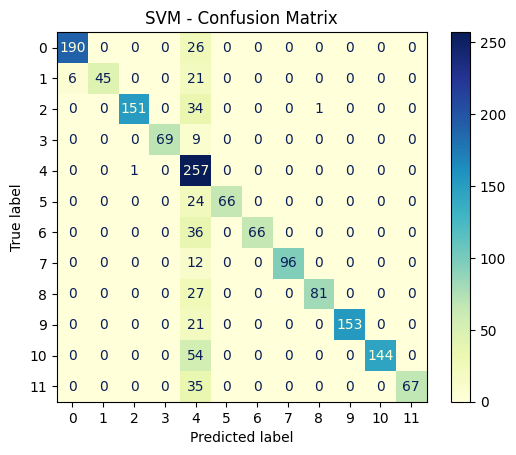

Test Accuracy (KNN): 97.93%

Random Sample Predictions:
Actual: 2, Predicted: 2
Actual: 3, Predicted: 3
Actual: 1, Predicted: 1
Actual: 10, Predicted: 10
Actual: 4, Predicted: 4
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 11, Predicted: 11
Actual: 4, Predicted: 4
Actual: 9, Predicted: 9


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       216
           1       0.92      0.93      0.92        72
           2       0.97      0.95      0.96       186
           3       1.00      1.00      1.00        78
           4       1.00      0.99      1.00       258
           5       1.00      1.00      1.00        90
           6       0.92      1.00      0.96       102
           7       1.00      1.00      1.00       108
           8       0.94      0.96      0.95       108
           9       1.00      0.99      1.00       174
          10       0.99      0.96      0.98       198
          11       1.0

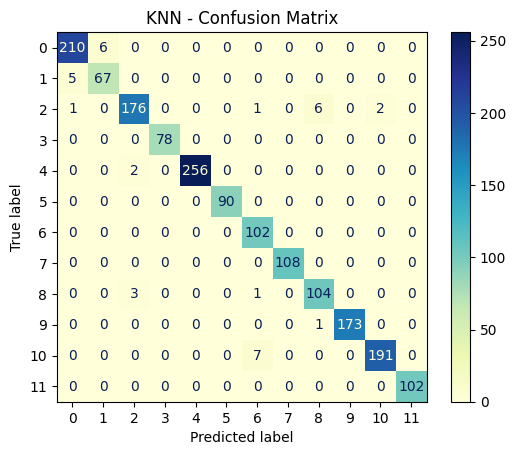

Test Accuracy (Random Forest): 98.05%

Random Sample Predictions:
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 5, Predicted: 5
Actual: 0, Predicted: 0
Actual: 10, Predicted: 10
Actual: 11, Predicted: 11
Actual: 10, Predicted: 10
Actual: 10, Predicted: 10
Actual: 7, Predicted: 7
Actual: 10, Predicted: 10


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       216
           1       1.00      0.92      0.96        72
           2       0.97      0.95      0.96       186
           3       1.00      1.00      1.00        78
           4       1.00      0.98      0.99       258
           5       1.00      1.00      1.00        90
           6       0.90      1.00      0.95       102
           7       0.98      1.00      0.99       108
           8       0.97      0.94      0.96       108
           9       1.00      1.00      1.00       174
          10       0.97      0.96      0.97       

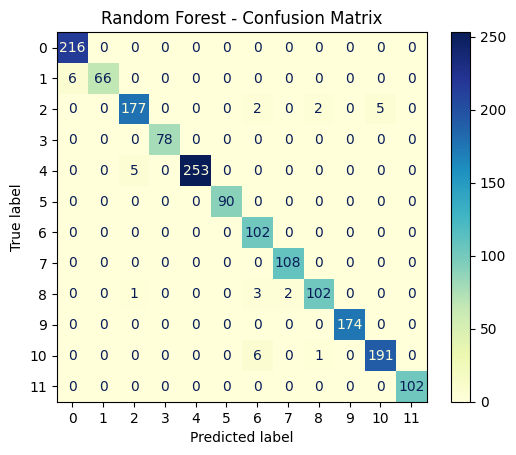

In [37]:
evaluate_loaded_model(loaded_svm, x_test, y_test, "SVM")
evaluate_loaded_model(loaded_knn, x_test, y_test, "KNN")
evaluate_loaded_model(loaded_rf, x_test, y_test, "Random Forest")